# **Preface** 

Maintenance of equipment is a critical activity for any business involving machines. Predictive maintenance is the method of scheduling maintenance based on the prediction about the failure time of any equipment. The machine learning models is constructed based on the datasets from turbo fan engine data from the Prognostics Data Repository of NASA. Using a training set, a model was constructed and was verified with a test data set. The results obtained were compared with the actual results to calculate the accuracy and the algorithm that results in maximum accuracy is identified. We have selected two machine learning algorithms for comparing the prediction accuracy.

In [105]:
# Importing required libraries 

import math
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

sns.set()

# **Data**

Our data includes data of 100 engines, each doing their respective number of cycles as per their functional lifecycle. During each cycle the sensors installed collects the data in each respective cycle. Based on this collected data we need to build a model which would predict the remaining useful life(**RUL**, time before which engine goes for maintenance to avoid unexpected breakdown) of a already/newly installed engine based on its current cycle data.  

In [106]:
#Importing data files

jet_data = pd.read_csv(r"E:\AI_ML_DL\PROJECT\Predictive Maintenance\CMaps\train_FD001.txt", sep=" ", header=None)
jet_rul = pd.read_csv(r"E:\AI_ML_DL\PROJECT\Predictive Maintenance\CMaps\RUL_FD001.txt", sep=" ", header=None)
test_data = pd.read_csv(r"E:\AI_ML_DL\PROJECT\Predictive Maintenance\CMaps\test_FD001.txt", sep = "\s+", header = None)
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]
test_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21"]

In [107]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [108]:
jet_rul.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [109]:
#sensor22
jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)


#adding the id column to jet rul 
jet_rul.columns = ['cycles', 'id']
jet_rul['id'] = jet_data['id'].unique()
jet_rul.set_index('id', inplace=True)
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

In [110]:
jet_data

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# **Data Manipulation**

The test data does not have RUL column so for model validation purposes we will add the column externally in the dataframe

In [111]:
#function to add RUL column to the data
def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"] 
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data, jet_id_and_rul)

In [112]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [113]:
#Preliminary analysis of data to understand the number of parameters and basic statistics
jet_data.describe()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


In [114]:
#checking the RUL data values 
jet_data.tail()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,2388.26,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0


#  EDA

###  **Visualizing Data**

We will visualize the data to determine the relevance of data and figure out the model determining attributes

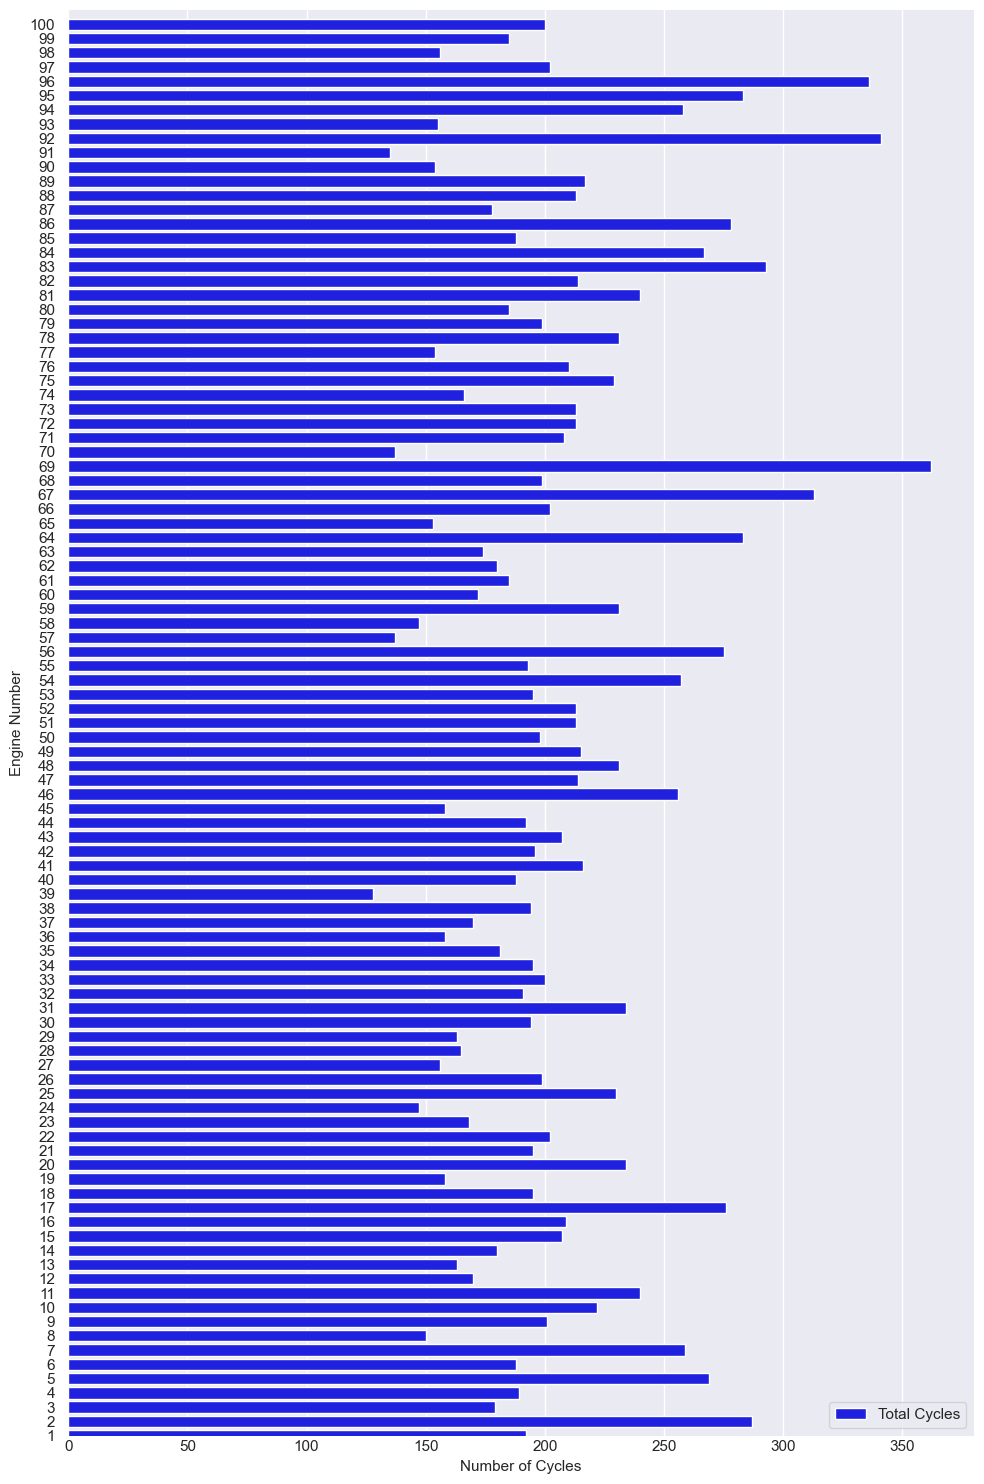

In [115]:
# Visualize total number of cycles by each engine

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="",xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

Mean number of cycles after which jet engine fails is 206


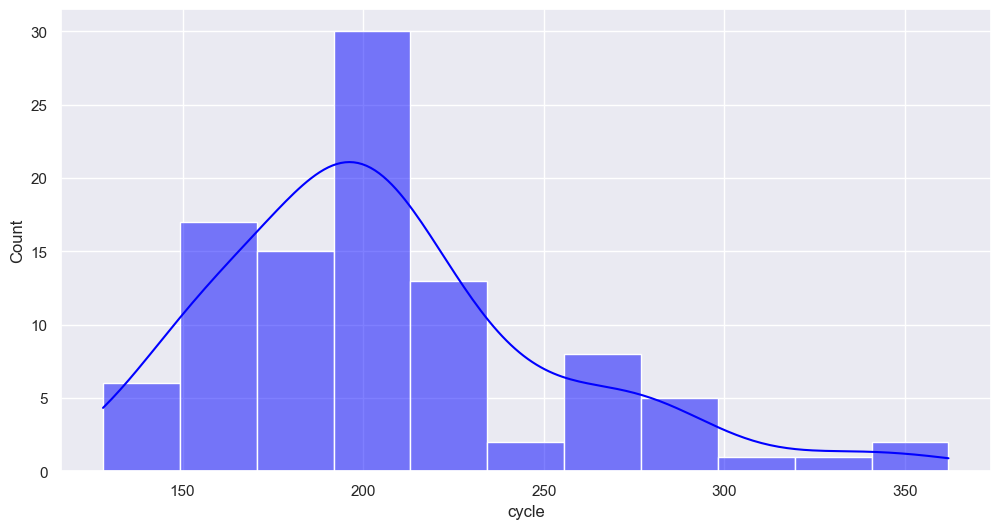

In [116]:
# Determining mean number of cycles and histogram of number of cycle

plt.subplots(figsize=(12, 6))
sns.histplot(jet_id_and_rul["cycle"], kde = True, color='blue');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(jet_id_and_rul["cycle"].mean())))

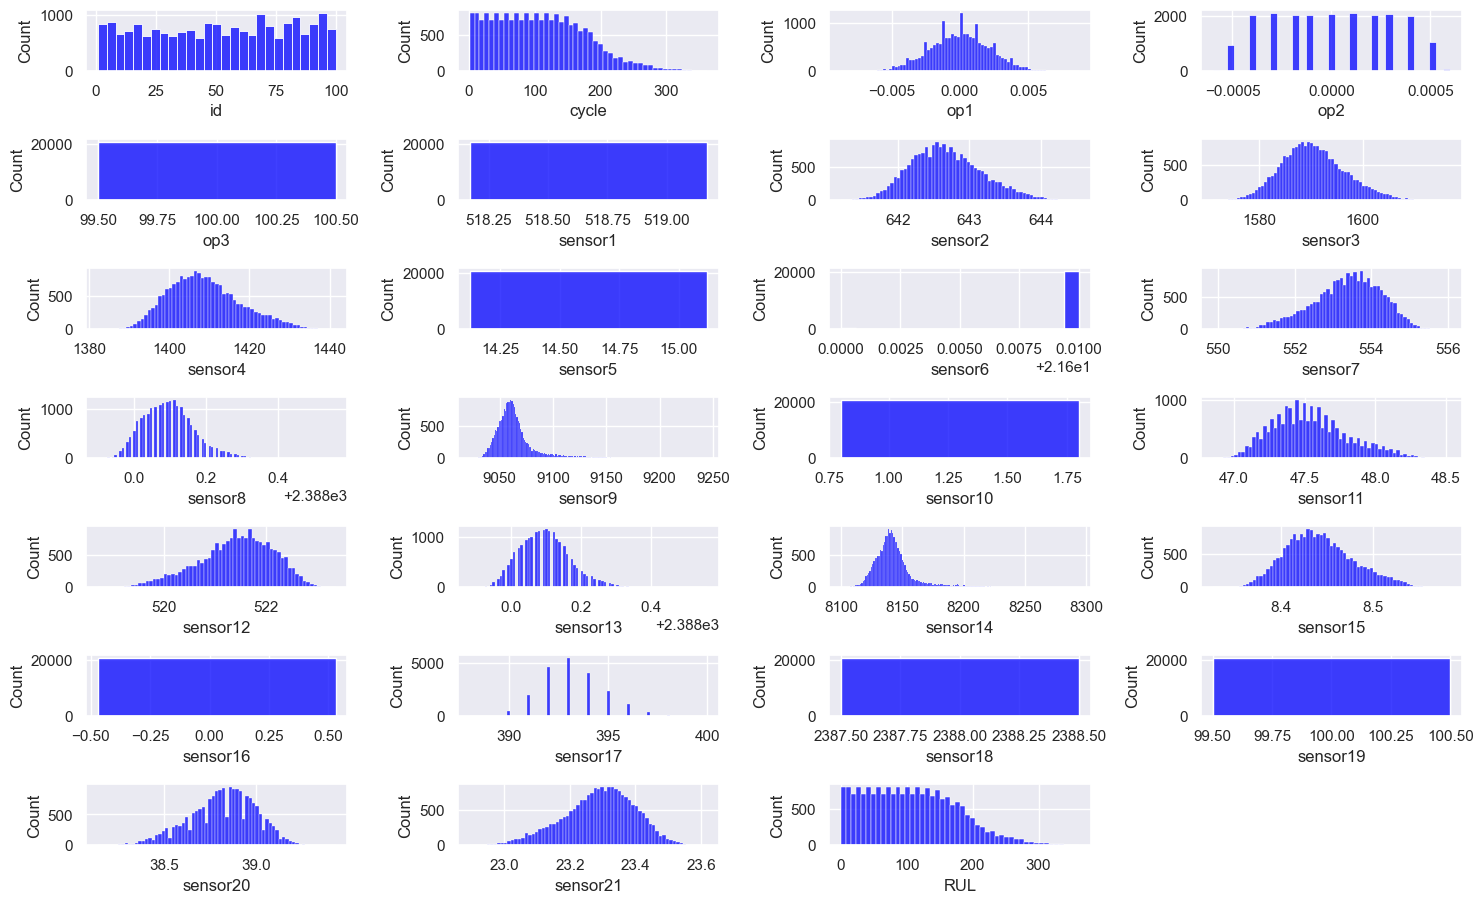

In [117]:
#Histogram representation of each sensor data

sns.set()
fig = plt.figure(figsize = [15,10])
cols = jet_data.columns
cnt = 1
for col in cols :
    plt.subplot(8,4,cnt)
    sns.histplot(jet_data[col],color='blue')
    cnt+=1
plt.tight_layout()
plt.show() 

As we could see there are many sensor data which aren't following the normal distribution, we will tend to ignore those sensors for our model training. We would try to reduce the curse of dimensionality by doing so. 

# **Correlation Matrix**

To see wheather the selected attributes are  related or not to each other. This way we will be able to reduce some more attributes, making our model free from overfitting. 

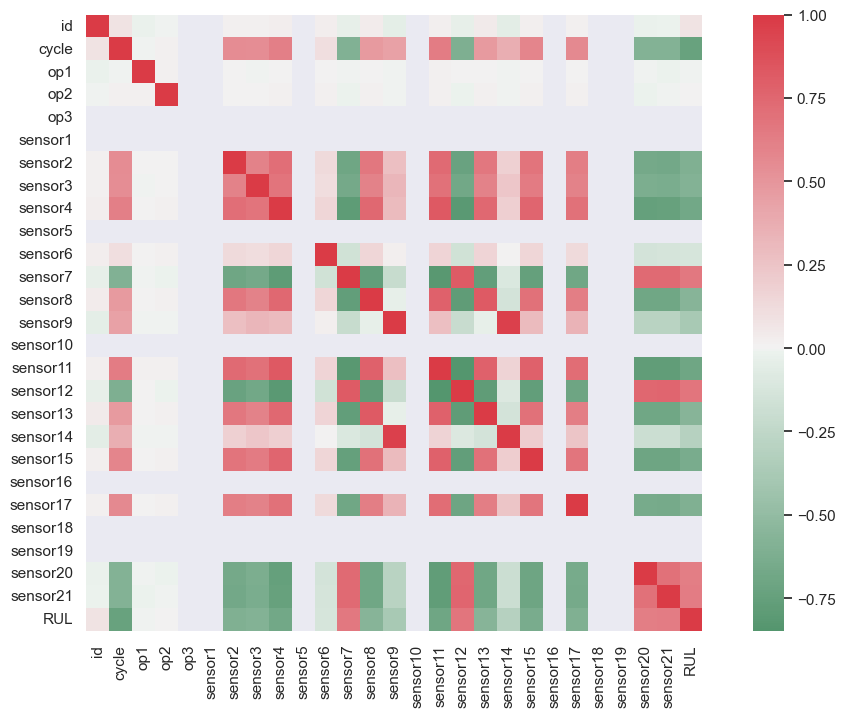

In [118]:
#Creating a heatmap to compare with RUL

plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

# Deletion of non contributing parameters into the analysis

Using the above correlation heatmap, We can safely ignore the parameters with lesser correlation with RUL. we can infer that the following parameters are not related to the RUL. 
* id, op1, op2, op3
* sensor1, sensor5, sensor6, sensor10
* sensor16, sensor18, sensor19

In [119]:
#New Dataframe with relevant parameters after droping the less correlated parameters

jet_relevant_data = jet_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"], axis=1)

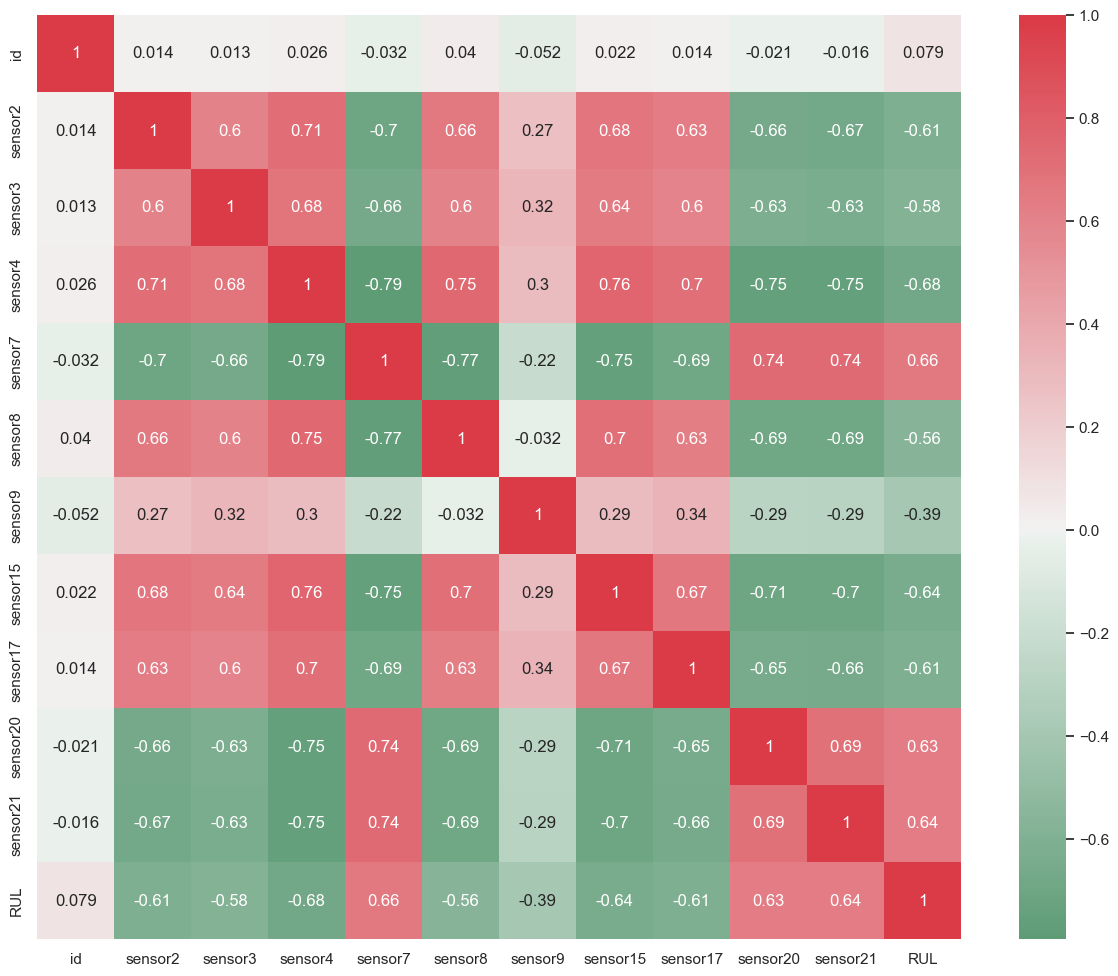

In [120]:
#Updated heatmap with relevant parameters

plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_relevant_data.corr(), cmap =cmap, center=0, annot=True, square=True);

In [121]:
def plot_sensor(sensor_name,X):
    plt.figure(figsize=(13,5))
    for i in X['id'].unique():
        if (i % 10 == 0):  # only plot every engine
            plt.plot('RUL', sensor_name, 
                     data=X[X['id']==i].rolling(8).mean())
            
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

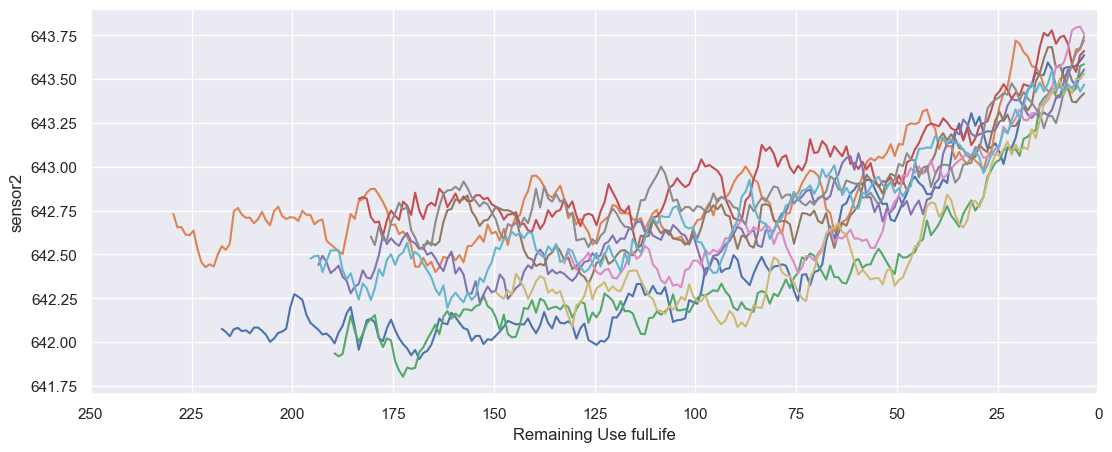

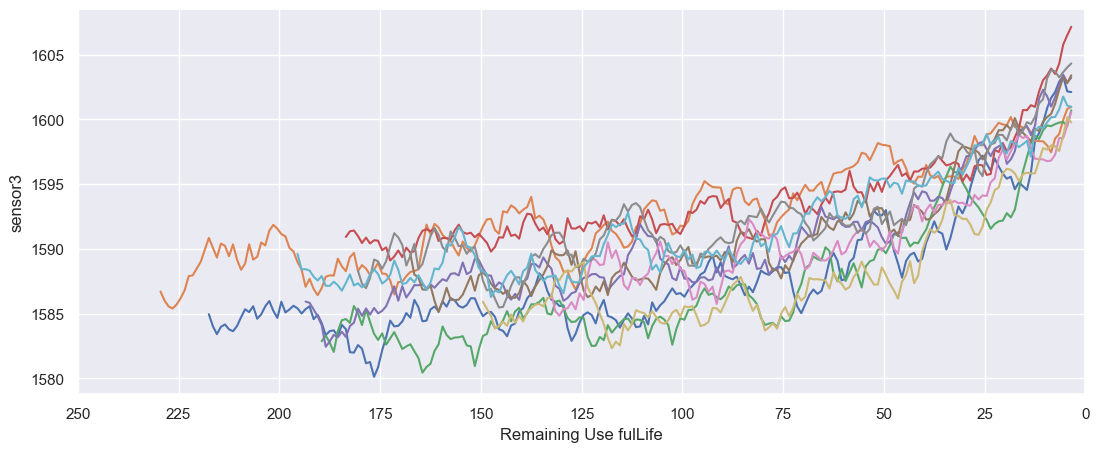

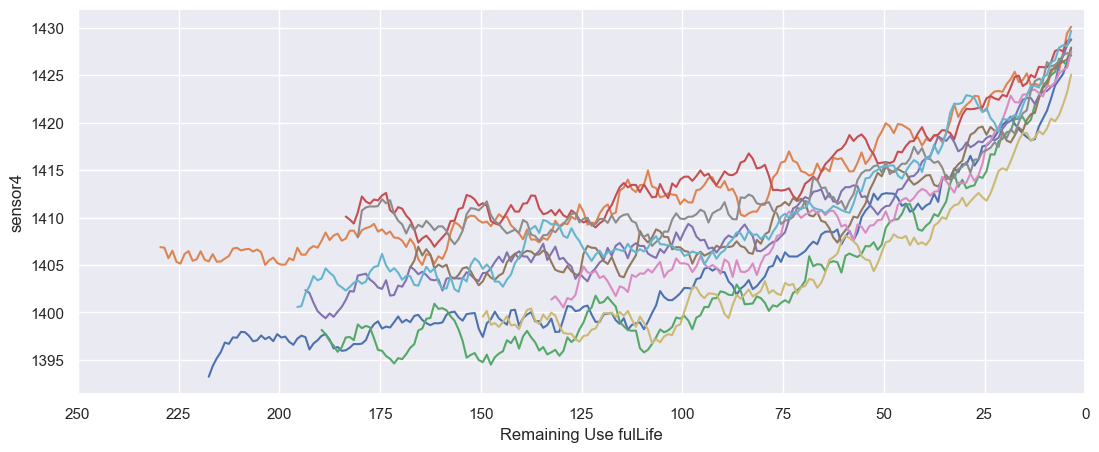

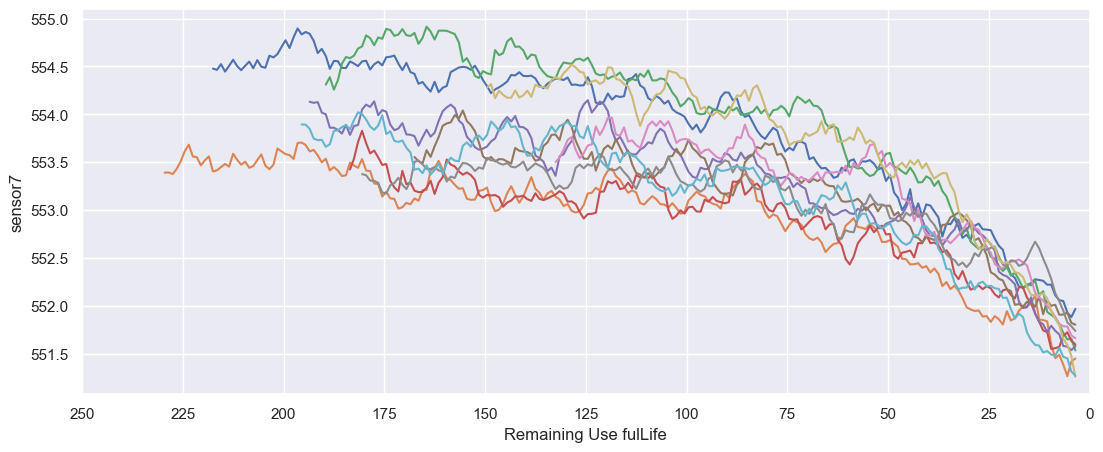

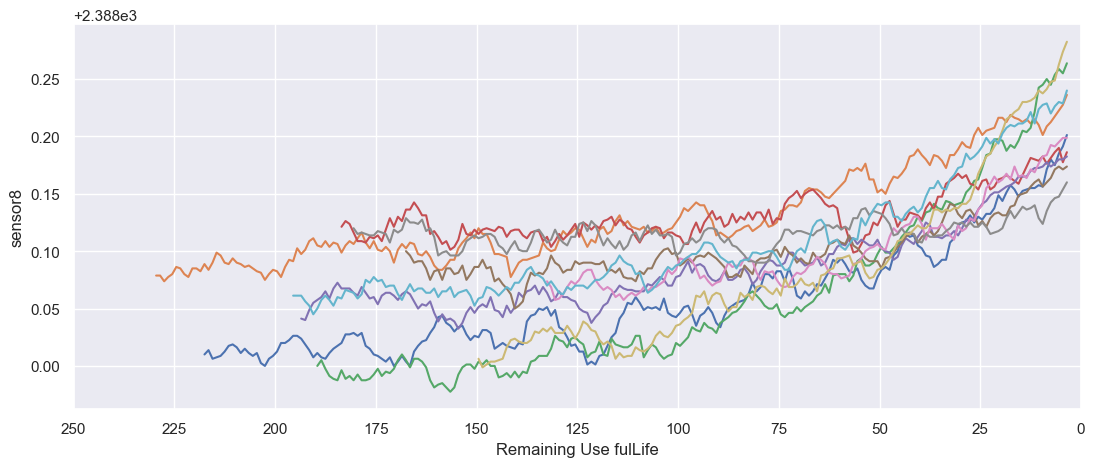

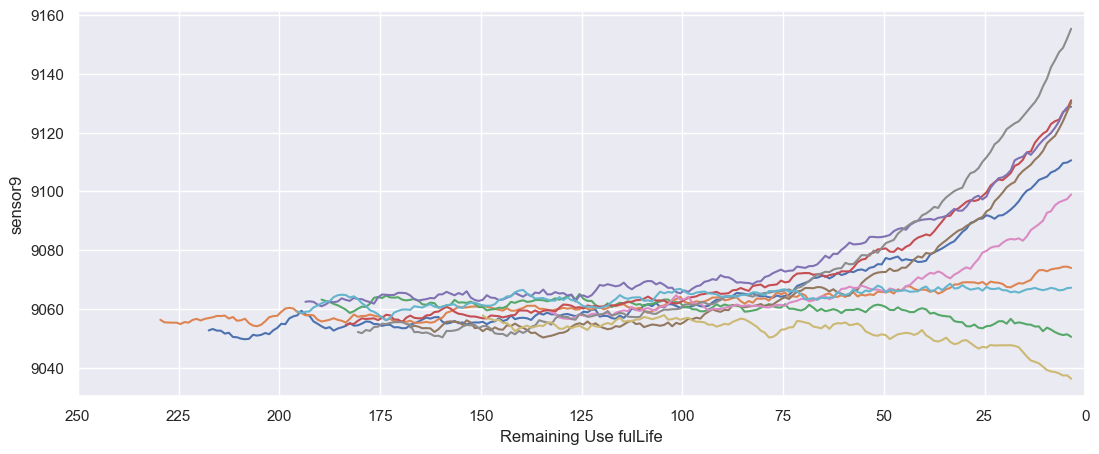

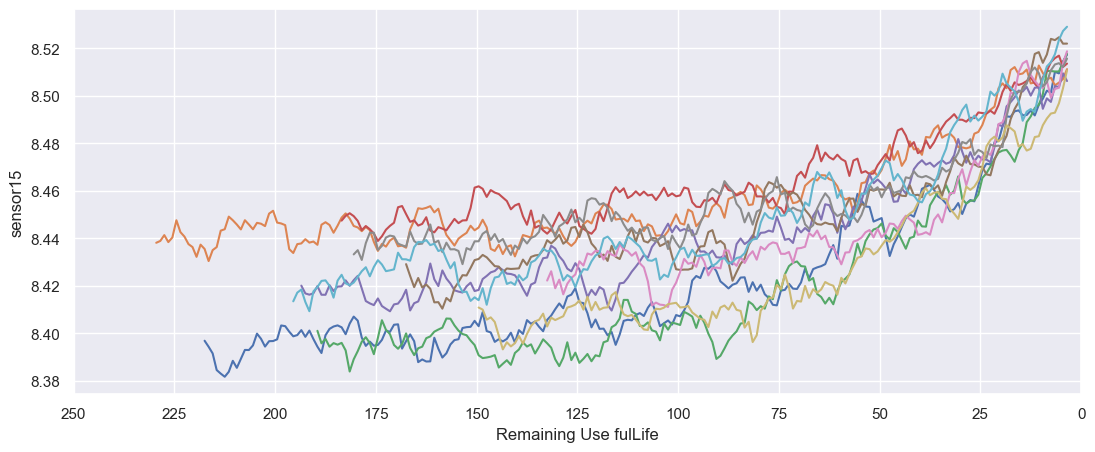

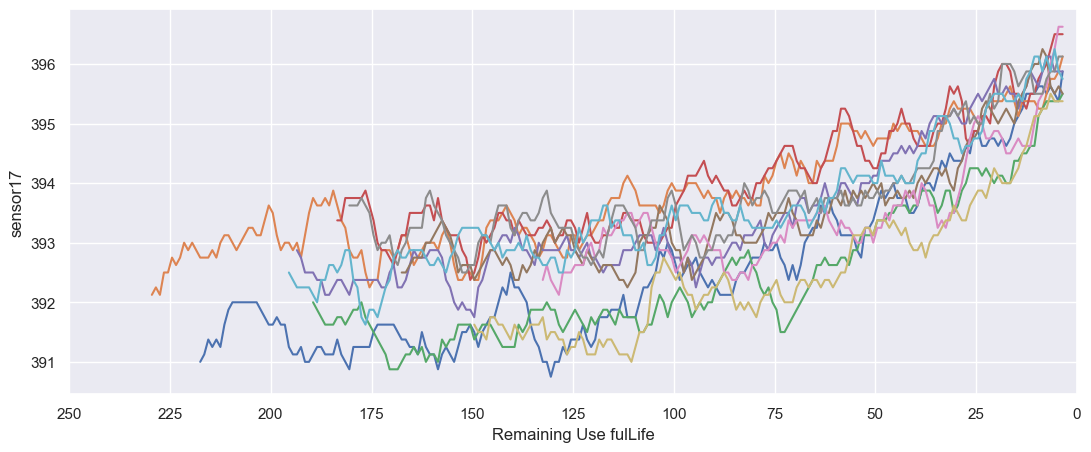

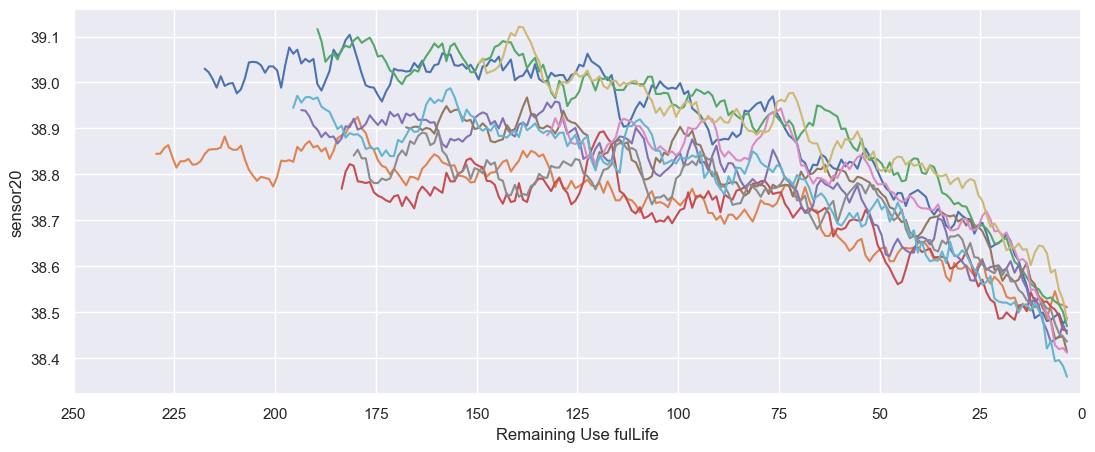

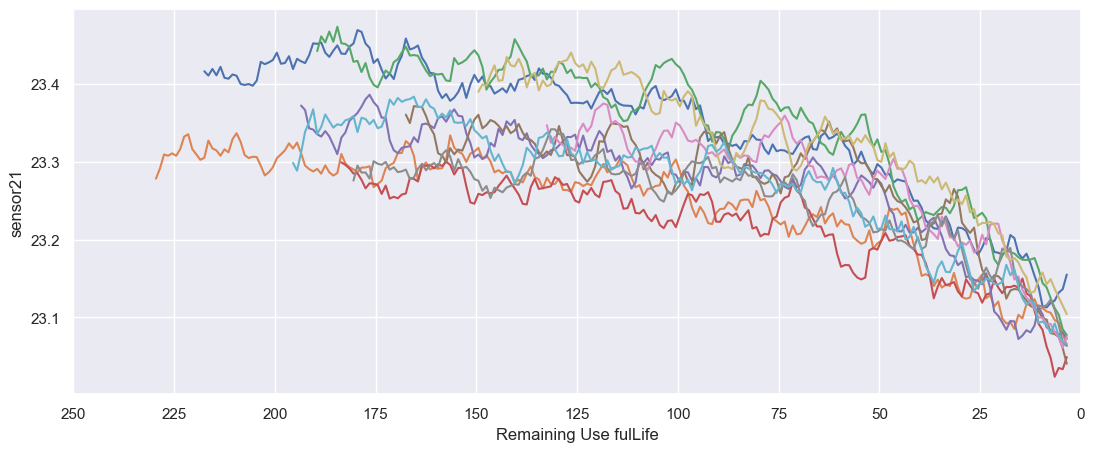

In [122]:
for sensor in jet_relevant_data.drop(['id', 'RUL'], axis=1).columns:
    plot_sensor(sensor, jet_relevant_data)

In [123]:
# Based on the above data variation, we removed sensor 9
jet_relevant_data.drop('sensor9', axis=1, inplace=True)

In [126]:
# Normalizing the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(jet_relevant_data.drop(['id', 'RUL'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=jet_relevant_data.drop(['id', 'RUL'], axis=1).columns)
scaled_features['RUL'] = jet_relevant_data['RUL']

In [132]:
#data splitting for Model training
y = scaled_features['RUL']
X = scaled_features.drop(['RUL'], axis=1)

X_train, X_cv, y_train, y_cv = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_cv shape : ',X_cv.shape)
print('y_train shape : ',y_train.shape)
print('y_cv shape : ',y_cv.shape)

X_train shape :  (16504, 9)
X_cv shape :  (4127, 9)
y_train shape :  (16504,)
y_cv shape :  (4127,)


In [133]:
import keras
model = keras.models.Sequential([
     keras.layers.Dense(64, activation="relu", input_shape=X_train.shape[1:]),
     keras.layers.Dense(32, activation="relu"),
     keras.layers.Dense(16, activation="relu"),
     keras.layers.Dense(8, activation="relu"),
     keras.layers.Dense(4, activation="relu"),
     keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam",metrics=(["accuracy","mse"]))
history = model.fit(X_train, y_train, epochs=30,validation_data=(X_cv, y_cv))
mse_test = model.evaluate(X_cv, y_cv)
X_new = X_cv[:3] # pretend these are new instances

y_pred= model.predict(X_new)


Epoch 1/30
516/516 [==============================] - 5s 6ms/step - loss: 5507.1826 - accuracy: 0.0051 - mse: 5507.1826 - val_loss: 2167.8755 - val_accuracy: 0.0051 - val_mse: 2167.8755
Epoch 2/30
516/516 [==============================] - 3s 5ms/step - loss: 2186.4465 - accuracy: 0.0048 - mse: 2186.4465 - val_loss: 2216.4421 - val_accuracy: 0.0051 - val_mse: 2216.4421
Epoch 3/30
516/516 [==============================] - 3s 5ms/step - loss: 2164.7495 - accuracy: 0.0048 - mse: 2164.7495 - val_loss: 2112.4751 - val_accuracy: 0.0051 - val_mse: 2112.4751
Epoch 4/30
516/516 [==============================] - 3s 5ms/step - loss: 2139.9199 - accuracy: 0.0048 - mse: 2139.9199 - val_loss: 2097.7268 - val_accuracy: 0.0051 - val_mse: 2097.7268
Epoch 5/30
516/516 [==============================] - 3s 5ms/step - loss: 2120.3276 - accuracy: 0.0048 - mse: 2120.3276 - val_loss: 2149.8999 - val_accuracy: 0.0051 - val_mse: 2149.8999
Epoch 6/30
516/516 [==============================] - 3s 5ms/step - lo

In [134]:
y_pred

array([[127.06737 ],
       [ 27.17291 ],
       [ 66.379364]], dtype=float32)

In [137]:
y_cv.head(3)

9775     133
17585     32
16843     41
Name: RUL, dtype: int64

In [138]:
def data_transform(df):
    df.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21"]
    df.drop(["id","cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6","sensor9", "sensor10", "sensor16", "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"],axis=1,inplace=True)
    scaled_features = scaler.transform(df)
    scaled_features = pd.DataFrame(scaled_features, columns= df.columns)
    
    return scaled_features

In [139]:
test_data = pd.read_csv(r"E:\AI_ML_DL\PROJECT\Predictive Maintenance\CMaps\test_FD001.txt", sep = "\s+", header = None)
test_data = data_transform(test_data)

In [140]:
test_data.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor15,sensor17,sensor20,sensor21
0,0.545181,0.310661,0.269413,0.652174,0.212121,0.308965,0.333333,0.558140,0.661834
1,0.150602,0.379551,0.222316,0.805153,0.166667,0.213159,0.416667,0.682171,0.686827
2,0.376506,0.346632,0.322248,0.685990,0.227273,0.458638,0.416667,0.728682,0.721348
3,0.370482,0.285154,0.408001,0.679549,0.196970,0.257022,0.250000,0.666667,0.662110
4,0.391566,0.352082,0.332039,0.694042,0.166667,0.300885,0.166667,0.658915,0.716377


In [141]:
model.predict(test_data)

410/410 [==============================] - 1s 3ms/step


array([[144.60144 ],
       [173.19539 ],
       [150.98653 ],
       ...,
       [ 55.34968 ],
       [ 43.47832 ],
       [ 20.367891]], dtype=float32)

# XGBOOST Model

In [142]:
# model tuning

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[10,20,50,100,200,500],
    #'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

reg = XGBRegressor(nthread=-1,verbose = 0,random_state=15)

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='r2')

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

[22:09:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample", "verbose" } are not used.

[22:09:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample", "verbose" } are not used.

[22:09:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample", "verbose" } are not used.

[22:09:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample", "verbose" } are not

In [143]:
best_regressor = random_search.best_estimator_
best_regressor

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.4,
             eval_metric='rmse', feature_types=None, gamma=0.4, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.400000006, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1, nthread=-1,
             num_parallel_tree=1, ...)

In [144]:
from sklearn.metrics import r2_score

# Get predictions
y_pred = best_regressor.predict(X_cv)

In [145]:
score=r2_score(y_cv,y_pred)
print('r2 score',score)

r2 score 0.5568078942100261


In [146]:
y_pred

array([124.69235 ,  22.540985,  64.799355, ..., 112.21119 , 136.89912 ,
        57.852055], dtype=float32)

In [147]:
y_cv.head(3)

9775     133
17585     32
16843     41
Name: RUL, dtype: int64